Original


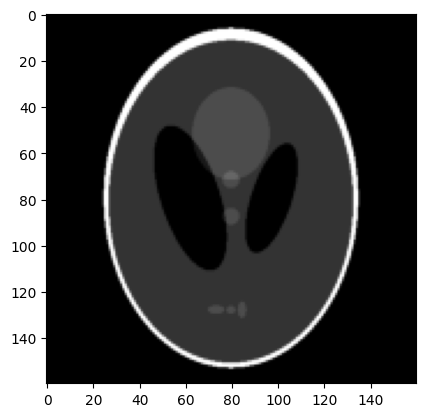

In [26]:
import numpy as np
import matplotlib.pyplot as plt 
from skimage import color, io, util, transform
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale

import matplotlib as mpl
mpl.rc('image', cmap='gray') #para no tener que pasar cmap='gray' cada vez que ploteo algo

#input = io.imread('gabu.jpg')
#image = util.img_as_float32(transform.resize(input, (257, 257), anti_aliasing=True))
#assert len(image.shape) == 2 and image.shape[0] == image.shape[1]
#image = image[...,0]

image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect', channel_axis=None)

N = image.shape[0]

print('Original')
plt.figure()
plt.imshow(image)


Sinograma


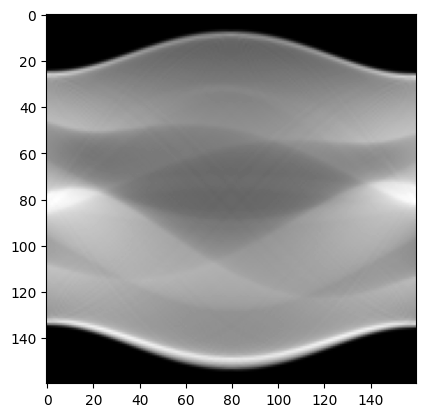

In [27]:
max_angle = 180.0 
angles = np.linspace(0.0, max_angle, N)
sinogram = transform.radon(image, theta=angles)

print('Sinograma')
plt.figure()
plt.imshow(sinogram)

In [28]:
angles

array([  0.        ,   1.13207547,   2.26415094,   3.39622642,
         4.52830189,   5.66037736,   6.79245283,   7.9245283 ,
         9.05660377,  10.18867925,  11.32075472,  12.45283019,
        13.58490566,  14.71698113,  15.8490566 ,  16.98113208,
        18.11320755,  19.24528302,  20.37735849,  21.50943396,
        22.64150943,  23.77358491,  24.90566038,  26.03773585,
        27.16981132,  28.30188679,  29.43396226,  30.56603774,
        31.69811321,  32.83018868,  33.96226415,  35.09433962,
        36.22641509,  37.35849057,  38.49056604,  39.62264151,
        40.75471698,  41.88679245,  43.01886792,  44.1509434 ,
        45.28301887,  46.41509434,  47.54716981,  48.67924528,
        49.81132075,  50.94339623,  52.0754717 ,  53.20754717,
        54.33962264,  55.47169811,  56.60377358,  57.73584906,
        58.86792453,  60.        ,  61.13207547,  62.26415094,
        63.39622642,  64.52830189,  65.66037736,  66.79245283,
        67.9245283 ,  69.05660377,  70.18867925,  71.32

reconstrucción con Python


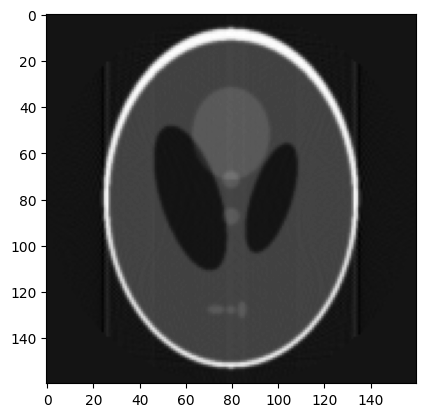

In [29]:
num_projection = N*len(angles)
r1 = transform.iradon(sinogram, theta=angles) #filter_name = alguno entre ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']
print('reconstrucción con Python')
plt.figure()
plt.imshow(r1)

reconstrucción ART


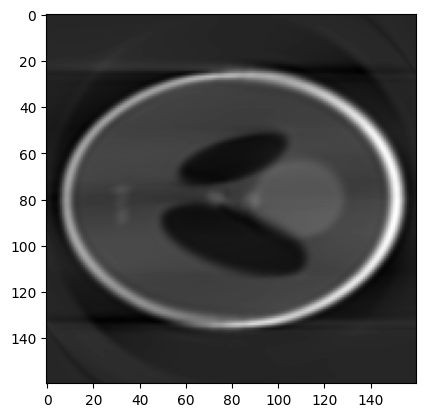

In [30]:
ir = np.zeros((N, N))
tdiff = np.zeros((N, N))
step = angles[1] - angles[0]
#L = len(ir)

niter = 1
for i in range(niter):
    for j in range(len(angles)):
        ir = transform.rotate(ir, step, order=3)
        tmp = sinogram[:,j].T * N
        temp = np.sum(ir, axis=1).T
        diff = (tmp - temp) / N
        
        for k in range(N):
            tdiff[:, k] = diff

        ir = ir + tdiff

print('reconstrucción ART')
plt.figure()
plt.imshow(ir)

reconstrucción FBP


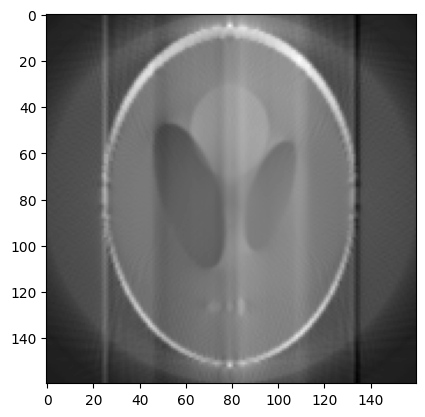

In [31]:
from scipy import fft

bp = np.zeros((N,N))
tmp = bp.copy()

ramlak = abs(np.linspace(-1,1,N).T)
#ramlak = np.ones(N).T


fft_R = fft.fftshift(fft.fft(sinogram))
filtproj = fft.ifftshift(fft_R * ramlak)
sg = np.real(fft.ifft(filtproj))

for i in range(N):
    tmp = np.tile(sg[:,i].T, (N, 1))
    tmp = transform.rotate(tmp, angles[i], order=1, clip=True)
    bp = bp + tmp

print('reconstrucción FBP')
plt.figure()
plt.imshow(bp)


## FBP V2

reconstrucción FBP


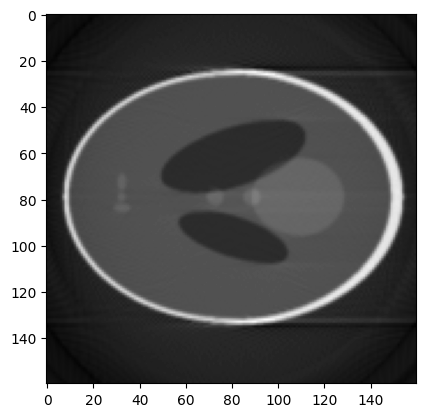

In [32]:

from scipy.fft import fft, fftshift, ifft, ifftshift

bp = np.zeros((len(sg),len(sg)))
tmp = bp.copy()

ramlak = abs(np.linspace(-1,1,len(sg)))

sinog = np.swapaxes(sinogram, 0, 1)
fft_R = fftshift(fft(sinog))
filtproj = ifftshift(fft_R * ramlak)
sg = np.real(ifft(filtproj))

sg = np.swapaxes(sg, 0, 1)


for i in range(len(sg[0,:])):
    tmp = np.repeat(sg[:,i], len(bp)).reshape((len(bp), len(bp)))
    tmp = transform.rotate(tmp, angles[i], order=1, clip=True)
    bp = bp + tmp

print('reconstrucción FBP')
plt.figure()
plt.imshow(bp)


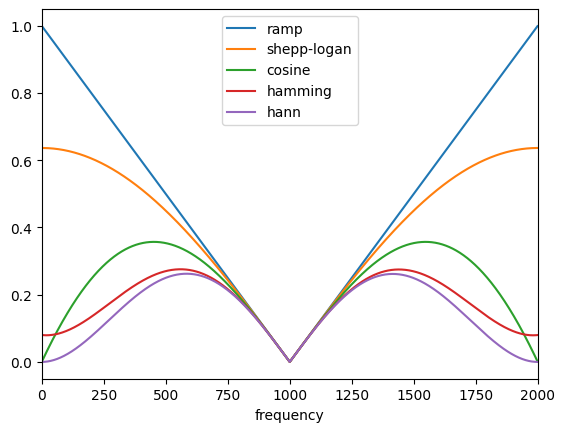

In [33]:
from skimage.transform.radon_transform import _get_fourier_filter

filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']

for ix, f in enumerate(filters):
    response = _get_fourier_filter(2000, f)
    plt.plot(fftshift(response), label=f)

plt.xlim([0, 2000])
plt.xlabel('frequency')
plt.legend()
plt.show()


In [34]:
ramlak = abs(np.linspace(-1,1,len(sg)))
ramlak

array([1.        , 0.98742138, 0.97484277, 0.96226415, 0.94968553,
       0.93710692, 0.9245283 , 0.91194969, 0.89937107, 0.88679245,
       0.87421384, 0.86163522, 0.8490566 , 0.83647799, 0.82389937,
       0.81132075, 0.79874214, 0.78616352, 0.77358491, 0.76100629,
       0.74842767, 0.73584906, 0.72327044, 0.71069182, 0.69811321,
       0.68553459, 0.67295597, 0.66037736, 0.64779874, 0.63522013,
       0.62264151, 0.61006289, 0.59748428, 0.58490566, 0.57232704,
       0.55974843, 0.54716981, 0.53459119, 0.52201258, 0.50943396,
       0.49685535, 0.48427673, 0.47169811, 0.4591195 , 0.44654088,
       0.43396226, 0.42138365, 0.40880503, 0.39622642, 0.3836478 ,
       0.37106918, 0.35849057, 0.34591195, 0.33333333, 0.32075472,
       0.3081761 , 0.29559748, 0.28301887, 0.27044025, 0.25786164,
       0.24528302, 0.2327044 , 0.22012579, 0.20754717, 0.19496855,
       0.18238994, 0.16981132, 0.1572327 , 0.14465409, 0.13207547,
       0.11949686, 0.10691824, 0.09433962, 0.08176101, 0.06918

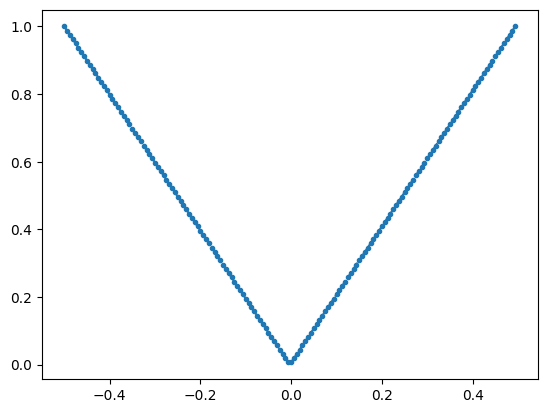

In [35]:
from scipy.fft import fftfreq

freqs = fftshift(fftfreq(len(ramlak)))

plt.plot(freqs, ramlak, '.--')
plt.show()

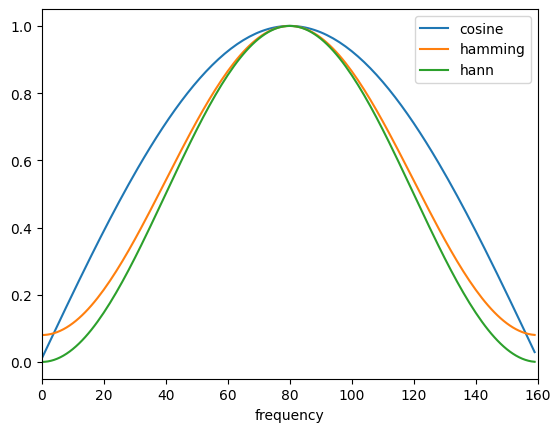

In [36]:
from scipy.signal import get_window

windows = ['cosine', 'hamming', 'hann']

for ix, f in enumerate(windows):
    response = get_window(f, len(ramlak))
    plt.plot(response, label=f)

plt.xlim([0, len(ramlak)])
plt.xlabel('frequency')
plt.legend()
plt.show()

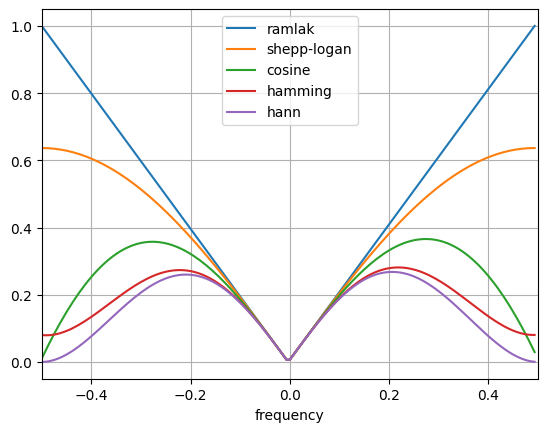

In [37]:
windows = ['cosine', 'hamming', 'hann']

plt.plot(freqs, ramlak, label='ramlak')

responses = {}

responses['ramlak'] = ramlak

sheppLogan = ramlak * np.sinc(ramlak/2)

plt.plot(freqs, sheppLogan, label='shepp-logan')

responses['shepp-logan'] = sheppLogan

for ix, f in enumerate(windows):
    response = get_window(f, len(ramlak))
    response *= ramlak
    responses[f] = response
    plt.plot(freqs, response, label=f)

plt.xlim([-0.5, 0.5])
plt.xlabel('frequency')
plt.legend()
plt.grid()
plt.show()

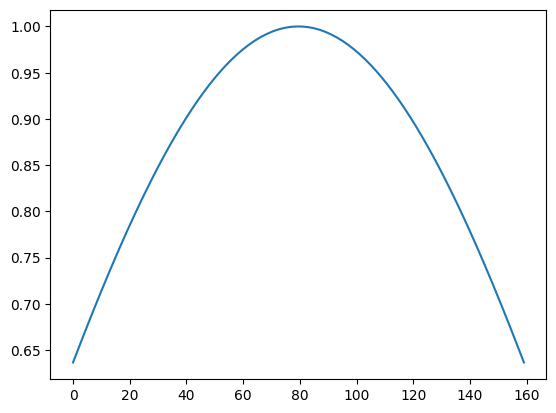

In [38]:
plt.plot(np.sinc(ramlak/2))
plt.plot()
plt.show()

reconstrucción FBP


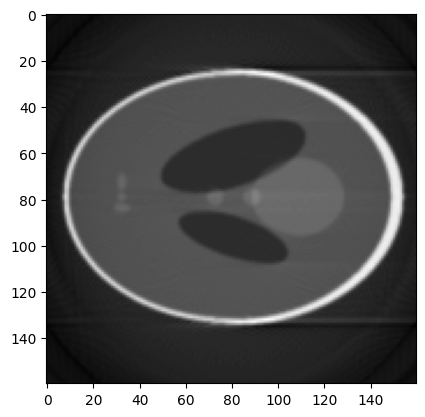

In [39]:
bp = np.zeros((len(sg),len(sg)))
tmp = bp.copy()

sinog = np.swapaxes(sinogram, 0, 1)
fft_R = fftshift(fft(sinog))
filtproj = ifftshift(fft_R * responses['shepp-logan'])
sg = np.real(ifft(filtproj))

sg = np.swapaxes(sg, 0, 1)


for i in range(len(sg[0,:])):
    tmp = np.repeat(sg[:,i], len(bp)).reshape((len(bp), len(bp)))
    tmp = transform.rotate(tmp, angles[i], order=1, clip=True)
    bp = bp + tmp

print('reconstrucción FBP')
plt.figure()
plt.imshow(bp)


In [40]:
len(bp[:,0])

160

In [41]:
a = np.array([1, 2])
b = a[:,None]

print(np.tile(a, (2, 1)))
print(np.tile(b, (2, 1)))

[[1 2]
 [1 2]]
[[1]
 [2]
 [1]
 [2]]


In [42]:
import scipy.sparse as sparse

#row_ptr = np.empty(N*N+1, dtype=np.int32)
#col_idx = []

#ptr = 0
#row_ptr[0] = ptr
#i = 1

A_ = set()

M = N//2

for rho in range(-M,M+1):
    for tau in range(-M, M+1):
        i = 0
        v = tau+rho*i
        while v < M*M:
            A_.add((i, v))
            i += 1
            v = tau+rho*i

        #row_ptr[i] = ptr
        #i += 1

        print(tau)
        

data = np.ones(len(A_), dtype=np.float32)

b = sinogram.flatten()
#A = A_.tocsr()
rows, cols = zip(*A_)
A = sparse.csr_matrix(np.ones(len(A_)), (rows, cols), dtype=np.float32)

test = image.flatten()

testout = (A @ test).reshape(N,N)

plt.figure()
plt.imshow(testout)

In [ ]:
import scipy.sparse as sparse

#row_ptr = np.empty(N*N+1, dtype=np.int32)
#col_idx = []

#A_ = sparse.dok_array((P*L, M*N), dtype=np.float32)

A_ = set()

M = N
R = N//2
S = M//2

def imggrid(dm, dn, sz):
    # imggrid -- Returns rectilinear coordinate vectors
    #
    # SYNOPSIS
    #   [ m n ] = imggrid(dm, dn, sz)
    #
    # DESCRIPTION
    #   Given the sample spacings and the image size, this
    #   function returns the row and column coordinate vectors
    #   for the image. Both vectors are centered about zero.
    #
    # INPUT
    #   dm     Spacing between rows.
    #   dn     Spacing between columns.
    #   sz     2x1 vector of the image size: [ Nrows Ncols ].
    #
    # OUTPUT
    #   m      sz(1) x 1 row coordinate vector.
    #   n      1 x sz(2) column coordinate vector.

    M_ = sz[0]
    N_ = sz[1]
    
    if M_ % 2 == 0:
      m = dm * np.arange(np.ceil(-M_/2), np.floor(M_/2) - 1)
    else:
      m = dm * np.arange(np.ceil(-M_/2), np.floor(M_/2))
    
    if N % 2 == 0:
      n = dn * np.arange(np.ceil(-N_/2), np.floor(N_/2) - 1)
    else:
      n = dn * np.arange(np.ceil(-N_/2), np.floor(N_/2))

    return m, n


# For each angle, we define a set of rays parameterized
# by rho. We then find the pixels on the RxS grid that
# are closest to each line. The elements in A corresponding
# to those pixels are given the value of 1.

# The maximum extent of the region of support. It's for
# rho = 0 and theta = pi/4, the line that runs caddy-corner.
W = int(np.round(np.sqrt(R*R + S*S)))

rho = np.linspace(-W/2, W/2, S)

print(rho.shape)

L = len(rho)
P = len(angles)

# Define a meshgrid w/ (0,0) in the middle that
# we can use a standard coordinate system.
mimg, nimg = imggrid(1, 1, [R, S])

ptr = 0
row_ptr[0] = ptr
i = 1

# We loop over each angle and define all of the lines.
# We then just figure out which indices each line goes
# through and put a 1 there.
for i in range(P):
    phi = angles[i] * np.pi/180

    # The equaiton is rho = m * sin(phi) + n * cos(phi).
    # We either define a vector for m and solve for n
    # or vice versa. We chose which one based on angle
    # so that we never g4et close to dividing by zero.
    if(phi >= np.pi/4 and phi <= 3*np.pi/4):
        t =  np.arange(-W,W,min(1/np.sqrt(2), abs(np.tan(phi))))
        T = len(t)

        rhom = np.tile(rho[:,None], (1, T))
        tn = np.tile(t, (L, 1))
        
        mline = (rhom - tn * np.cos(phi)) / np.sin(phi)

        for j in range(L):            
            p = np.round(tn[j,:] - min(nimg)).astype(int)
            q = np.round(mline[j,:] - min(mimg)).astype(int)

            for x in q:
                for y in p:
                    #A_[i*L+j, x*S+y] = 1
                    A_.add((i*L+j, x*S+y))

    else:
        t =  np.arange(-W,W,min(1/np.sqrt(2), 1/abs(np.tan(phi))))
        T = len(t)

        rhon = np.tile(rho, (T, 1))   
        tm = np.tile(t[:,None], (1, L))

        nline = (rhon - tm * np.sin(phi)) / np.cos(phi)
    
        for j in range(L):
            p = np.round(nline[:,j] - min(nimg)).astype(int)
            q = np.round(tm[:,j] - min(mimg)).astype(int)
            
            for x in q:
                for y in p:
                    #A_[i*L+j, x*S+y] = 1
                     A_.add((i*L+j, x*S+y))

            #columnas = list(set(S*q+p))
            #columnas.sort()

            #col_idx.extend(columnas)
            #ptr += len(columnas)
            #row_ptr[i] = ptr
            #i += 1

    print(i)


#ptr = 0
#row_ptr[0] = ptr
#i = 1
#for rho in range(0,N):
#    for tau in range(0, N):
#        v = tau
#        while v < N*N:
#            col_idx.append(v)
#            v += N+rho
#            ptr += 1

#        row_ptr[i] = ptr
#        i += 1
        

#data = np.ones(len(col_idx), dtype=np.float32)

b = sinogram.flatten()
#A = A_.tocsr()
rows, cols = zip(*A_)
A = sparse.csr_matrix(np.ones(len(A_)), (rows, cols), dtype=np.float32)

test = image.flatten()

testout = (A @ test).reshape(M,N)

plt.figure()
plt.imshow(testout)

(128,)


/tmp/ipykernel_11325/3978396737.py:103: RuntimeWarning: divide by zero encountered in scalar divide
  t =  np.arange(-W,W,min(1/np.sqrt(2), 1/abs(np.tan(phi))))


0
1
2
3
4
5
6
7
8
9


KeyboardInterrupt: 

reconstrucción FISTA


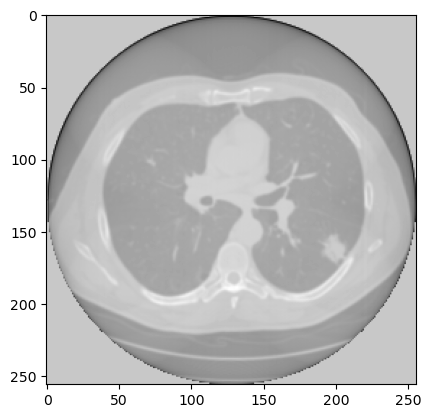

In [ ]:
niter = 50
lambd = 0.1
L = 1e-4
t = 1
f = np.zeros((N,N))
fp = f.copy()
y = f.copy()

for i in range(niter):
    d = y - L * transform.iradon(transform.radon(y, theta=angles) - sinogram, theta=angles)
    #f = np.max((abs(d) - lambd * L)) * np.sign(d)
    f = d - lambd * L
    f /= np.max(np.abs(f))
    tp = (1+np.sqrt(1+4*t*t))/2
    y = f + (t - 1)/tp * (f - fp)
    fp = f.copy()
    t = tp

print('reconstrucción FISTA')
plt.figure()
plt.imshow(f)

    

In [ ]:



AT = A.T
ATB =  AT @ b
#ATA = AT @ A

menosgradf = lambda x: (AT @ (A @ x)) - ATB

x = np.zeros(N*N, dtype=np.float32)

for k in range(10):
    dir = menosgradf(x)
    a = dir.T @ ATB
    b = np.linalg.norm(A @ dir)
    alfa = (a)/(b*b)
    x += alfa*dir

print(np.linalg.norm(menosgradf(x)))

gc = x.reshape(N, N)

print('reconstrucción GC')

plt.figure()
plt.imshow(gc)

TypeError: expected a sequence of integers or a single integer, got '16385.0'